In [25]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer

# Data base import

In [98]:
from utils.split_feelings import split

PATH_TRAIN = Path("../data/samples/sample_1000_train.csv")
PATH_VALID = Path("../data/samples/sample_100_validation.csv")

SPLIT_FEELINGS = True

if SPLIT_FEELINGS:
    POSITIVES_WITH_NEGATIVES = True

    train_pos, train_neutral, train_neg = split(PATH_TRAIN, POSITIVES_WITH_NEGATIVES)
    valid_pos, valid_neutral, valid_neg = split(PATH_VALID, POSITIVES_WITH_NEGATIVES)
    
    train_data = train_neutral
    validation_data = valid_neutral

else:
    train_data = pd.read_csv(PATH_TRAIN).to_numpy()
    validation_data = pd.read_csv(PATH_VALID).to_numpy()

In [99]:
print(train_data.shape, validation_data.shape)

(334, 4) (40, 4)


In [100]:
from utils.clean_data import clean_data 

train_data = clean_data(train_data)
traivalidation_data = clean_data(validation_data)

In [101]:
print(train_data.shape, validation_data.shape)

(333, 4) (40, 4)


# Pre-processing

In [102]:
# -- Get the original tweets -- #

X_TR_ORIGINAL = train_data[:, 1]
X_VAL_ORIGINAL = validation_data[:, 1]

Y_TR_ORIGINAL = train_data[:, 2]
Y_VAL_ORIGINAL = validation_data[:, 2]

FEELINGS_TR = train_data[:, 3]
FEELINGS_VAL = validation_data[:, 3]

In [103]:
from descriptors.tokenizer.tokenizer import Tokenizer
from descriptors.tweet_string.create_strings import create_strings

# -- Define the tokenizer -- #
TOKENIZER = Tokenizer()

# -- Create sentences -- #
X_TR_STRING = create_strings(X_TR_ORIGINAL, TOKENIZER)
X_VAL_STRING = create_strings(X_VAL_ORIGINAL, TOKENIZER)

Y_TR_STRING = create_strings(X_TR_ORIGINAL, TOKENIZER)
Y_VAL_STRING = create_strings(X_VAL_ORIGINAL, TOKENIZER)

print(X_VAL_STRING[0])

['What', 'are', 'we', 'doin', '!', '!', '?', '?', 'Tell', 'me', '!', 'tell', 'me', '!']


In [104]:
from descriptors.descriptor_ascii.load_data import load_data
from descriptors.tweet_label.create_labels import create_labels

# ALPHANUM_ONLY = False
# SPLIT_PUNCTUATION = False  # to tell wheter the puncutation "!?.;,/" etc are keeped sticked to a word or not

WORD_SIZE = 30
SENTENCE_SIZE = 50
FILL_WITH = "$"
FEELING_WEIGHT = 1


# training set --------------------------------------------
X_TR_STRING_FILLED, X_TR_SCALAR = load_data(
    X_TR_STRING, WORD_SIZE, SENTENCE_SIZE, FILL_WITH, FEELING_WEIGHT, feelings=FEELINGS_TR)

Y_TR = create_labels(X_TR_STRING, Y_TR_STRING, SENTENCE_SIZE)


# validation set ------------------------------------------
X_VAL_STRING, X_VAL_SCALAR = load_data(
    X_VAL_STRING, WORD_SIZE, SENTENCE_SIZE, FILL_WITH, FEELING_WEIGHT, feelings=FEELINGS_VAL)

Y_VAL = create_labels(X_VAL_STRING, Y_VAL_STRING, SENTENCE_SIZE)

In [105]:
IDX = 0
print("Original data :")
print(X_TR_ORIGINAL[IDX])
print("\nFilled sentence :")
print(X_TR_STRING_FILLED[IDX])
print("\nLabel :")
print(Y_TR[IDX])
print("\nDescriptor :")
print(X_TR_SCALAR[IDX])

Original data :
twice in a week Qantas club lounge computers broken  #flyertalk

Filled sentence :
['twice$$$$$$$$$$$$$$$$$$$$$$$$$' 'in$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 'a$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' 'week$$$$$$$$$$$$$$$$$$$$$$$$$$'
 'Qantas$$$$$$$$$$$$$$$$$$$$$$$$' 'club$$$$$$$$$$$$$$$$$$$$$$$$$$'
 'lounge$$$$$$$$$$$$$$$$$$$$$$$$' 'computers$$$$$$$$$$$$$$$$$$$$$'
 'broken$$$$$$$$$$$$$$$$$$$$$$$$' '#flyertalk$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$

### Standardisation

In [106]:
mu = np.concatenate([X_TR_SCALAR[:, :-1].mean(axis=0), [0]])
sigma = X_TR_SCALAR[:, :-1].std(axis=0)

X_TR_SCALAR = X_TR_SCALAR - mu
X_VAL_SCALAR = X_VAL_SCALAR - mu

for i in range(len(sigma)):
    if sigma[i] != 0:
        X_TR_SCALAR[:, i] /= sigma[i]
        X_VAL_SCALAR[:, i] /= sigma[i]

# Classification

In [107]:
#!pip install xgboost

In [108]:
from sklearn.multioutput import MultiOutputRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [125]:
nb_neighbors = 10
# regressor = KNeighborsRegressor(nb_neighbors, weights="distance", metric="jaccard")
regressor = KNeighborsRegressor(nb_neighbors, weights="distance")

# regressor = MultiOutputRegressor(
#     xgb.XGBClassifier(objective="reg:logistic")
# )

#regressor = MultiOutputRegressor(
#    SVR(kernel="poly", degree=2)
#)

regressor.fit(X_TR_SCALAR, Y_TR)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='distance')

In [126]:
predictions = regressor.predict(X_VAL_SCALAR)

In [127]:
from utils.post_processing import preds_to_strings

results_val = preds_to_strings(X_VAL_ORIGINAL, X_VAL_STRING, predictions)

In [128]:
from utils.loss import mean_jaccard

accuracy = mean_jaccard(validation_data[:, 2], results_val)
print(accuracy)

38.9051976346094


In [58]:
def test_knn(n):
    regressor = KNeighborsRegressor(n, weights="distance", metric="jaccard")
    regressor.fit(X_TR_SCALAR, Y_TR)
    predictions = regressor.predict(X_VAL_SCALAR)
    results_val = preds_to_strings(X_VAL_ORIGINAL, X_VAL_STRING, predictions)
    accuracy = mean_jaccard(validation_data[:, 2], results_val)
    
    return accuracy

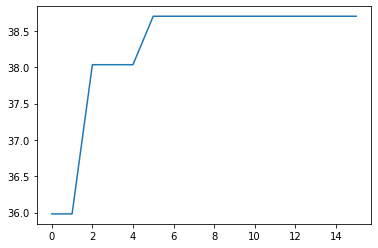

In [59]:
y =[]
for i in range(2,50, 3):
    y.append(test_knn(i))
plt.plot(y)
plt.show()